In [1]:
from tqdm import tqdm

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
from ase import io
from ase.visualize import view
from ase.build import sort, molecule
from ase.optimize import QuasiNewton, FIRE

In [5]:
from helpers import validate
from helpers import read_metrics

In [6]:
from pyace import PyACECalculator

In [7]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['font.size'] = 18
# mpl.rcParams['font.family'] = 'Times'

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 3.
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.top']=True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 3.
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right']=True

In [8]:
calc = PyACECalculator('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.yaml',
    keep_extrapolative_structures=True,
    gamma_lower_bound=1.2,
    gamma_upper_bound=10,
    stop_at_large_extrapolation=False)
calc.set_active_set('../../upfit/10000_ladder/asi/interim_potential_ladder_step_1.asi')

In [9]:
def linear_fn(x, a, b):
    return a*x + b

In [10]:
import os
import warnings
def read_log(path):
    os.system(f'cat {path}/lmp.out | grep -e Step -e Loop -n > read_log')
    file = open('read_log').readlines()
#     os.system('rm read_log')
    log_lst = list()
    for i in range(0,len(file),2):
        try:
                n1 = int(file[i].replace(':',' ').split()[0])
                n2 = int(file[i+1].replace(':',' ').split()[0])
                log_lst.append(pd.read_csv(f'{path}/lmp.out',
                                   skiprows=n1-1, nrows=n2-n1-1, sep= '\s+'))
        except:
            break

    if(len(file)%2 ==0):
        return log_lst
    else:
        warnings.warn('Last run is not finished')            
        n = int(file[-1].replace(':',' ').split()[0])
        log_lst.append(pd.read_csv(f'{path}/lmp.out', skiprows=n-1, sep= '\s+'))

    return log_lst

In [11]:
def write_lmp_file_eq(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
  f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',           
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 20000 \n',
 '\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 'dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 'dump_modify     3 element H O\n',            
 '\n',
 'fix             3 all nph aniso ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             2000000\n',
 '\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_lmp_file(T, P, path, pot_dir):
    s= np.random.randint(99999)
    lines= ['\n',
 'units\t\tmetal\t\t\t\t\t\t## E in [eV], t in [ps], P in [10000 Pa], l in [A]\n',
 'atom_style\tatomic\t\t\t\t\t\t## mass x y z vx vy vz \n',
 '\n',
 'neighbor\t0.5 bin\t\t\t\t\t\t## neighbor list, skin = 0.5 Angstrom\n',
 'neigh_modify\tevery 2 delay 10 check yes\t\t\t## update of neighbor list\n',
 '\n',
 '############################## main variables\n',
 f'variable        seed equal {s}\n',
 '\n',
 f'variable\ttemperature equal {T}\n',
 'variable\ttempDamp equal 0.1\n',
 '\n',
 f'variable        pressure equal {P}\n',
 'variable        pressureDamp equal 1.0 \t\t\t\t# This is 1 ps\n',
 '\n',
 '##############################\n',
 '\n',
 'read_data water.dat\n',
 '\n',
 'mass\t\t1 1.008    # H\n',
 'mass\t\t2 15.9994  # O\n',
 '\n',
 '\n',
 'pair_style\tpace/extrapolation\n',
 f'pair_coeff\t* * {pot_dir}/interim_potential_ladder_step_1.yaml {pot_dir}/interim_potential_ladder_step_1.asi H O\n',
 '\n',
 'fix pace_gamma all pair 1000 pace/extrapolation gamma 1\n',
 'compute max_pace_gamma all reduce max f_pace_gamma\n',
 'variable dump_skip equal "c_max_pace_gamma < 10"\n',
 '\n',
 'dump pace_dump all custom 1000 extrapolative_structures.dump id type x y z f_pace_gamma\n',
 'dump_modify pace_dump skip v_dump_skip\n',
 'dump_modify pace_dump element H O\n',
 '\n',
 'variable max_pace_gamma equal c_max_pace_gamma',
 '\n',
 '\n',
 'timestep\t0.0005\t\t\t\t\t\t## timestep = 0.0005*ps = 0.5 fs\n',
 '\n',
 'thermo\t\t100\n',
 'thermo_style custom step etotal pe ke press temp vol density c_max_pace_gamma\n',
 '\n',
 '\n',
 'min_style cg\n',
 'minimize 0.0 5.0e-4 10000 100000\n'
 '\n',
 '################## equilibration of main calculation\n',
 '# Equilibrate to specified number of ice\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.equil.dat outfile plumed.out\n',
 'fix             3 all nph z ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run 200000 \n',
 '\n',
 'unfix 1\n',
 'unfix 3\n',
 'unfix 4\n',
 '\n',
 '################## main calculation\n',
 '\n',
 '#dump \t\t3 all custom 1000 traj.lammpstrj id type element x y z\n',
 '#dump_modify     3 element H O\n',
 '\n',
 '\n',
 'fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out\n',
 'fix             3 all nph z ${pressure} ${pressure} ${pressureDamp}\n',
 'fix             4 all temp/csvr ${temperature} ${temperature} ${tempDamp} ${seed}\n',
 'velocity \tall create ${temperature} ${seed} dist gaussian\n',
 '\n',
 'run             20000000\n',
 '\n',
 'unfix\t\t1\n',
 'unfix\t\t3\n',
 'unfix\t\t4\n',]
    fr = open(f'{path}/in.lammps', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_strict(sigma, intersect, path):
    lines=['\n',
     '# Strict counting of molecules\n',
     'ENVIRONMENTSIMILARITY ...\n',
     ' SPECIES=1441-2160:1\n',
     f' SIGMA={sigma}\n',
     ' CRYSTAL_STRUCTURE=BCC\n',
     ' LATTICE_CONSTANTS=0.34072718272556335\n'
     ' LABEL=refcv2\n',
     ' MORE_THAN={CUBIC '+ f'D_0={intersect} D_MAX={intersect}0001'+'}\n',
     ' MEAN\n',
     '... ENVIRONMENTSIMILARITY\n']
    fr = open(f'{path}/plumed.strict.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_smooth(sigma, x_ice, x_liq, path):
    lines = ['ENVIRONMENTSIMILARITY ...\n',
     ' SPECIES=1441-2160:1\n',
     f' SIGMA={sigma}\n',
     ' CRYSTAL_STRUCTURE=BCC\n',
     ' LATTICE_CONSTANTS=0.34072718272556335\n'
     ' LABEL=refcv\n',
     ' MORE_THAN={'+f'CUBIC D_0={x_ice} D_MAX={x_liq}'+'}\n',
     ' MEAN\n',
     '... ENVIRONMENTSIMILARITY\n']
    fr = open(f'{path}/plumed.smooth.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return
    

def write_plumed_eq_file(cv_min, cv_max, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 f'uwall: UPPER_WALLS ARG=refcv.morethan AT={cv_max} KAPPA=1.0 EXP=2 STRIDE=2\n',
 f'lwall: LOWER_WALLS ARG=refcv.morethan AT={cv_min} KAPPA=1.0 EXP=2 STRIDE=2\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR-EQUIL\n']
    fr = open(f'{path}/plumed.equil.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_plumed_file(T, cv_min, cv_max, path):
    lines= ['# vim:ft=plumed\n',
 '\n',
 '\n',
 'INCLUDE FILE=plumed.smooth.dat\n',
 '\n',
 f'umb1: ECV_UMBRELLAS_LINE ARG=refcv.morethan TEMP={T} CV_MIN={cv_min} CV_MAX={cv_max} SIGMA=1 BARRIER=50\n',
 'opes: OPES_EXPANDED ARG=umb1.* PACE=500 STRIDE=2 WALKERS_MPI\n',      
 '\n',
 f'uwall: UPPER_WALLS ARG=refcv.morethan AT={cv_max+5} KAPPA=1.0 EXP=2 STRIDE=2\n',
 f'lwall: LOWER_WALLS ARG=refcv.morethan AT={cv_min-5} KAPPA=1.0 EXP=2 STRIDE=2\n',
 '\n',
 'INCLUDE FILE=plumed.strict.dat\n',
 '\n',
 '\n',
 'PRINT STRIDE=500  ARG=* FILE=COLVAR\n']
    fr = open(f'{path}/plumed.start.dat', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_mrn(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --account=cicn2\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=4\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=3-00:00:00\n'
    '#SBATCH --gres=gpu:4\n'
    '#SBATCH --qos=acc_resa\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load mkl intel cuda/12.2 openmpi/4.1.5-gcc fftw/3.3.10-gcc-ompi gsl/2.8-gcc lammps/7Feb2024\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp_mpi -k on g 4  -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_hyp(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=1\n'
    '#SBATCH --cpus-per-task=20\n'
    '#SBATCH --time=8-00:00:00\n'
    '#SBATCH --gres=gpu:1\n'
    '#SBATCH --constraint=gpu-icelake|gpu-cascadelake\n'
    '#SBATCH --partition=general\n'
    '#SBATCH --qos=xlong\n'
    '\n'
    '\n'
    'module purge\n'
    'ml load LAMMPS/27Jun2024-foss-2021b-kokkos-PLUMED-2.8.0-CUDA-11.4.1\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp -k on g 1 -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

def write_sbatch_zgh(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --time=7-23:59:00\n'
    '#SBATCH --partition=compute\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=28\n'
    '#SBATCH --cpus-per-task=2\n'
    '\n'
    '\n'
    'module purge\n'
    'module load lammps/latest-gnu-z\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'mpirun -np 28 lmp_mpi  -in in.lammps  > lmp.out'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    
def write_sbatch_pc2(path, name='ace-pd'):
    lines = [
    '#!/bin/bash\n'
    f'#SBATCH --job-name={name}\n'
    '#SBATCH --nodes=1\n'
    '#SBATCH --ntasks-per-node=1\n'
    '#SBATCH --cpus-per-task=128\n'
    '#SBATCH --time=2-00:00:00\n'
    '#SBATCH --gres=gpu:a100:1\n'
    '#SBATCH --partition=gpu\n'
    '#SBATCH --mem=40GB\n'
    '\n'
    '\n'
    'module purge\n'
    'module load chem/LAMMPS/27Jun2024-foss-2023b-kokkos-CUDA-12.5.0\n'
    'export PLUMED_NUM_THREADS=${SLURM_CPUS_PER_TASK}\n'
    'export SRUN_CPUS_PER_TASK=${SLURM_CPUS_PER_TASK}\n'
    'srun lmp -k on g 1 -sf kk -pk kokkos newton on neigh half -in in.lammps > lmp.out\n'
    ]
    fr = open(f'{path}/sbatch.sh', 'w')
    fr.writelines(lines)
    fr.close()
    return

In [79]:
from scipy.optimize import curve_fit

def linear_fn(x, a, b):
    return a*x + b

In [377]:
def plot_stats_eq(path, skip=0):
    #Read the data from the path
    
    data = pd.read_csv(f'{path}/COLVAR-EQUIL',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    log = read_log(f'{path}/')[1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=4)
    
    ax[0].plot(data['time'][skip:]*1E-3, data['refcv.morethan'][skip:], alpha=1., c='k')
    ax[0].axhline(np.average(data['refcv.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice,strict}}$')
    
    ax[1].plot(data['time'][skip:]*1E-3, data['refcv2.morethan'][skip:], alpha=1., c='k')
    ax[1].axhline(np.average(data['refcv2.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('$\mathrm{n_{ice,smooth}}$')

    ax[2].plot(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=1., c='k')
    ax[2].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('T [K]')

    ax[3].plot(log.Step[skip:]*5e-7,log.Press[skip:]*1e-4, alpha=1., c='k')
    ax[3].axhline(log.Press[skip:].mean()*1e-4, ls='--', color='w', lw=2)
    ax[3].set_xlabel('Time [ns]')
    ax[3].set_title('P [GPa]')
    
def plot_stats(path, skip=0):
    #Read the data from the path
    
    data = pd.read_csv(f'{path}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)
    log = read_log(f'{path}/')[-1]
        
    fig, ax = plt.subplots(figsize=(16,4), ncols=4)
    
    ax[0].plot(data['time'][skip:]*1E-3, data['refcv.morethan'][skip:], c='k')
    ax[0].axhline(np.average(data['refcv.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[0].set_xlabel('Time [ns]')
    ax[0].set_title('$\mathrm{n_{ice,strict}}$')
    
    ax[1].plot(data['time'][skip:]*1E-3, data['refcv2.morethan'][skip:], c='k')
    ax[1].axhline(np.average(data['refcv2.morethan'][skip:]), ls='--', color='w', lw=2)
    ax[1].set_xlabel('Time [ns]')
    ax[1].set_title('$\mathrm{n_{ice,smooth}}$')

    ax[2].scatter(log.Step[skip:]*5e-7, log.Temp[skip:], alpha=.1, c='k')
    ax[2].axhline(log.Temp[skip:].mean(), ls='--', color='w', lw=2)
    ax[2].set_xlabel('Time [ns]')
    ax[2].set_title('T [K]')

    ax[3].scatter(log.Step[skip:]*5e-7,log.Press[skip:]*1e-4, alpha=.1, c='k')
    ax[3].axhline(log.Press[skip:].mean()*1e-4, ls='--', color='w', lw=2)
    ax[3].set_xlabel('Time [ns]')
    ax[3].set_title('P [GPa]')
    return data

In [338]:
def plot_cv_hist(path, T_lst):
    fig, ax = plt.subplots(figsize=(3*len(T_lst),3), ncols=len(T_lst), sharey=True)

    colors = plt.cm.viridis(np.linspace(0,1,len(T_lst)))
    colors = ['k']*len(T_lst)
    for i, T in enumerate(T_lst):
        data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
        data.columns = np.roll(data.columns,-2)

        dpl=0.05 # Lower probability range for strict histogram
        dph=0.05 # Upper probability range for strict histogram
        dh=1     # Bin size used for histogram
        ig=2000 # Ignore the first 1500 frames
        atm_to_gpa=0.000101325

        time_ns = data['time'][ig:]/1E3
        number_of_ice  = data['refcv2.morethan'][ig:]

        histo, bin_edges = np.histogram(number_of_ice,bins=300)
        n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

        # Determine outer range of strict collective variable histogram
        cumsum=np.cumsum(histo)
        cumsum=cumsum/cumsum.max()
        difference=np.abs(cumsum-dpl)
        ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
        difference=np.abs(cumsum-(1-dph))
        nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


        # Plot biased histogram
        num_ice_bins=[i for i in range(ns,nf+1)]
        bins2=[i for i in range(ns-10,nf+10)]
        histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
        n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

        ax[i].plot(n_ice_mid,histo, c='k')
        ax[i].axvline(x=ns,linewidth=4, color='k',ls='--')
        ax[i].axvline(x=nf,linewidth=4, color='k',ls='--')
        ax[i].set_title(f'T={T} K')
        ax[i].set_xlabel('$\mathrm{n_{ice}}$')

In [343]:
def get_cv_hist(path, T, bins=1000):
    data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    ig=2000 # Ignore the first 1500 frames
    atm_to_gpa=0.000101325

    time_ns = data['time'][ig:]/1E3
    number_of_ice  = data['refcv2.morethan'][ig:]

    histo, bin_edges = np.histogram(number_of_ice,bins=bins)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]
    bins2=[i for i in range(ns-10,nf+10)]
    histo, bin_edges = np.histogram(number_of_ice,bins=bins2[::dh],density=True)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])
    
    return n_ice_mid, histo, nf, ns

In [340]:
def plot_fes(path, T_lst):
    fig, ax = plt.subplots(figsize=(3*len(T_lst),3), ncols=len(T_lst), sharey=True)

    colors = plt.cm.viridis(np.linspace(0,1,len(T_lst)))
    colors = ['k']*len(T_lst)
    for i, T in enumerate(T_lst):
        data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
        data.columns = np.roll(data.columns,-2)

        dpl=0.05 # Lower probability range for strict histogram
        dph=0.05 # Upper probability range for strict histogram
        dh=1     # Bin size used for histogram
        ign=2000 # Ignore the first 1500 frames        ign = 2000

        number_of_ice  = data['refcv2.morethan'][ign:]
        bias_potential = data['opes.bias'][ign:]

        histo, bin_edges = np.histogram(number_of_ice,bins=80)
        n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

        # Determine outer range of strict collective variable histogram
        cumsum=np.cumsum(histo)
        cumsum=cumsum/cumsum.max()
        difference=np.abs(cumsum-dpl)
        ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
        difference=np.abs(cumsum-(1-dph))
        nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


        # Plot biased histogram
        num_ice_bins=[i for i in range(ns,nf+1)]

        beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

        logweights = beta*bias_potential
        logweights -= np.amax( logweights)

        bins=num_ice_bins[::dh]
        histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
        histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

        fes = -(1/beta)*np.log(histo)
        fes -= np.mean(fes)
        fes_error = (1/beta)*histo_error/histo
        bin_centers = bin_centers


    #     fes_error = (1/beta)*histo_error/histo
    #     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
    #     fes = fes[args]
    #     fes_error = fes_error[args]
    #     bin_centers = bin_centers[args]


        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

        n_water = bin_centers
        fes_linear = linear_fn(bin_centers,*popt)
        perr = np.sqrt(np.diag(pcov))[0]
        chem_pot = [popt[0],perr]

        ax[i].scatter(n_water,fes, c=colors[i])
        ax[i].plot(n_water,fes_linear, c='w')
        ax[i].set_title(f'T={T} K')   
        ax[i].set_xlabel('N ice')
        ax[0].set_ylabel(r'$\Delta$G$_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')

In [281]:
def get_cv(path, T):
    data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    ign=2000 # Ignore the first 1500 frames        ign = 2000

    number_of_ice  = data['refcv2.morethan'][ign:]
    time = data['time'][ign:]/1e3

   

    return time,number_of_ice

In [378]:
def get_fes(path, T):
    data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
    data.columns = np.roll(data.columns,-2)

    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    ign=2000 # Ignore the first 1500 frames        ign = 2000

    number_of_ice  = data['refcv2.morethan'][ign:]
    bias_potential = data['opes.bias'][ign:]

    histo, bin_edges = np.histogram(number_of_ice,bins=300)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax( logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    fes_error = (1/beta)*histo_error/histo
    bin_centers = bin_centers


#     fes_error = (1/beta)*histo_error/histo
#     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
#     fes = fes[args]
#     fes_error = fes_error[args]
#     bin_centers = bin_centers[args]


    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

    n_water = bin_centers
    fes_linear = linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    chem_pot = [popt[0],perr]

    return n_water, fes, fes_linear

In [379]:
def get_chem_pot(path, T_lst):
    chem_pot_lst = np.zeros((len(T_lst),3))
    for i, T in enumerate(T_lst):
        data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
        data.columns = np.roll(data.columns,-2)

        dpl=0.05 # Lower probability range for strict histogram
        dph=0.05 # Upper probability range for strict histogram
        dh=1     # Bin size used for histogram
        ign=2000 # Ignore the first 1500 frames        ign = 2000

        number_of_ice  = data['refcv2.morethan'][ign:]
        bias_potential = data['opes.bias'][ign:]

        histo, bin_edges = np.histogram(number_of_ice,bins=1000)
        n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

        # Determine outer range of strict collective variable histogram
        cumsum=np.cumsum(histo)
        cumsum=cumsum/cumsum.max()
        difference=np.abs(cumsum-dpl)
        ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
        difference=np.abs(cumsum-(1-dph))
        nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


        # Plot biased histogram
        num_ice_bins=[i for i in range(ns,nf+1)]

        beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

        logweights = beta*bias_potential
        logweights -= np.amax(logweights)

        bins=num_ice_bins[::dh]
        histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
        histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

        fes = -(1/beta)*np.log(histo)
        fes -= np.mean(fes)

        fes_error = (1/beta)*histo_error/histo

    #     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
    #     fes = fes[args]
    #     fes_error = fes_error[args]
    #     bin_centers = bin_centers[args]
    #     args = np.argsort(fes_error)

        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

        n_water = bin_centers
        fes_linear = linear_fn(bin_centers,*popt)
        perr = np.sqrt(np.diag(pcov))[0]
        chem_pot = [popt[0],perr]
        chem_pot_lst[i,0] = T
        chem_pot_lst[i,1] = popt[0]
        chem_pot_lst[i,2] = perr

        popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=100)

    return chem_pot_lst[:,0],chem_pot_lst[:,1],linear_fn(chem_pot_lst[:,0],*popt),np.round(-popt[1]/popt[0],3),pcov

In [41]:
def plot_chem_pot(path, T_lst):
    chem_pot_lst = np.zeros((len(T_lst),3))
    for i, T in enumerate(T_lst):
        data = pd.read_csv(f'{path}/{T}/COLVAR',sep= '\s+')
        data.columns = np.roll(data.columns,-2)

        dpl=0.05 # Lower probability range for strict histogram
        dph=0.05 # Upper probability range for strict histogram
        dh=1     # Bin size used for histogram
        ign=2000 # Ignore the first 1500 frames        ign = 2000

        number_of_ice  = data['refcv2.morethan'][ign:]
        bias_potential = data['opes.bias'][ign:]

        histo, bin_edges = np.histogram(number_of_ice,bins=1000)
        n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

        # Determine outer range of strict collective variable histogram
        cumsum=np.cumsum(histo)
        cumsum=cumsum/cumsum.max()
        difference=np.abs(cumsum-dpl)
        ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
        difference=np.abs(cumsum-(1-dph))
        nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


        # Plot biased histogram
        num_ice_bins=[i for i in range(ns,nf+1)]

        beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

        logweights = beta*bias_potential
        logweights -= np.amax(logweights)

        bins=num_ice_bins[::dh]
        histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
        histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

        fes = -(1/beta)*np.log(histo)
        fes -= np.mean(fes)

        fes_error = (1/beta)*histo_error/histo

    #     args = np.isfinite(fes) & np.isfinite(fes_error) & (fes_error != 0)
    #     fes = fes[args]
    #     fes_error = fes_error[args]
    #     bin_centers = bin_centers[args]
    #     args = np.argsort(fes_error)

        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)

        n_water = bin_centers
        fes_linear = linear_fn(bin_centers,*popt)
        perr = np.sqrt(np.diag(pcov))[0]
        chem_pot = [popt[0],perr]
        chem_pot_lst[i,0] = T
        chem_pot_lst[i,1] = popt[0]
        chem_pot_lst[i,2] = perr

        popt, pcov = curve_fit(linear_fn, chem_pot_lst[:,0], chem_pot_lst[:,1], maxfev=100)


    plt.figure(figsize=(5,3))
    plt.scatter(chem_pot_lst[:,0],chem_pot_lst[:,1], c='k')
    plt.plot(chem_pot_lst[:,0],linear_fn(chem_pot_lst[:,0],*popt), c='k')
    plt.axhline(0, ls='--', c='k')
    plt.axvline(-popt[1]/popt[0], ls=':', label=f'T={np.round(-popt[1]/popt[0],3)} K', c='k')
    plt.ylabel(r'$\Delta\mu_{\mathrm{liq}\to \mathrm{ice}}$ (kJ mol$^{-1}$)')
    plt.xlabel('Temperature (K)')    
    plt.legend(frameon=False)

## Ice Ih

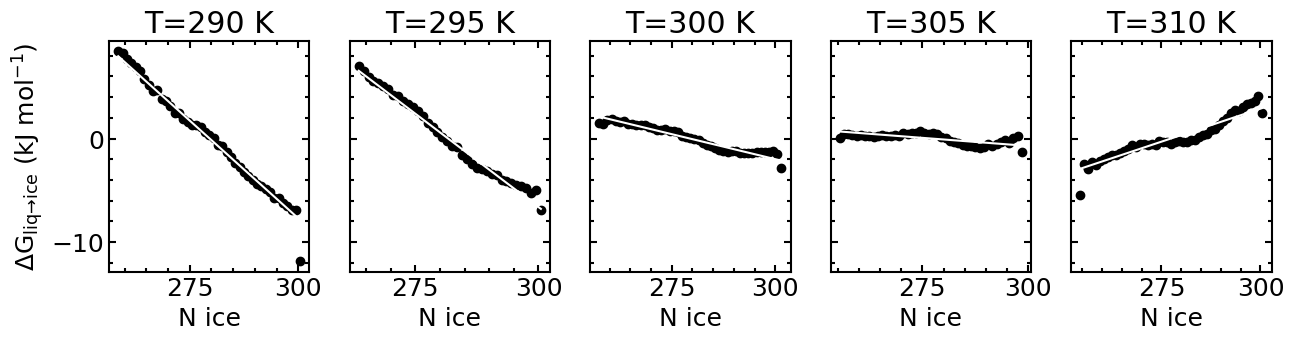

In [104]:
T_lst = np.arange(290,311,5, dtype=int)
path = f'../../full/ih/0_bar/2-coex/'
plot_fes(path, T_lst)

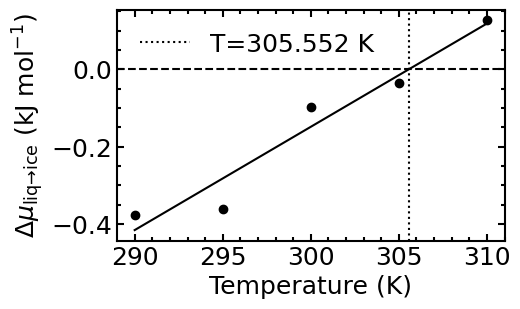

In [43]:
T_lst = np.arange(290,311,5, dtype=int)
path = f'../../full/ih/0_bar/2-coex/'
plot_chem_pot(path, T_lst)

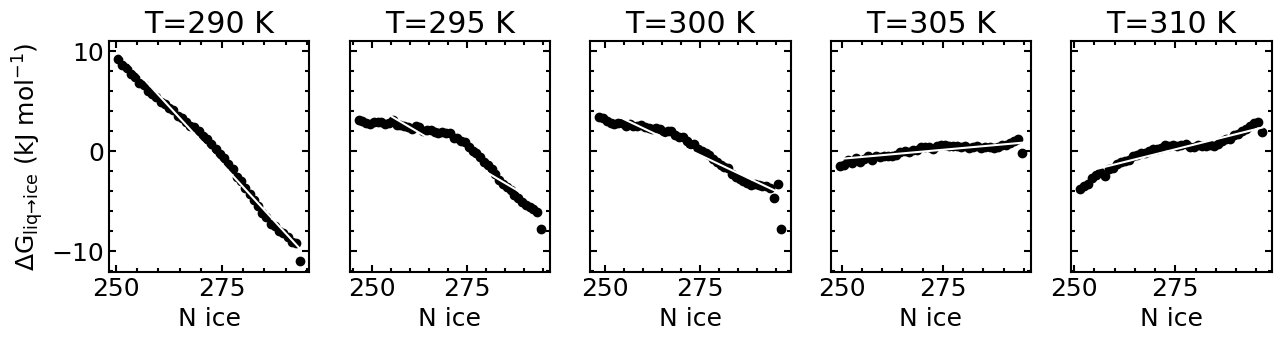

In [106]:
T_lst = np.arange(290,311,5, dtype=int)
path = f'../../full/ih/100_bar/2-coex/'
plot_fes(path, T_lst)

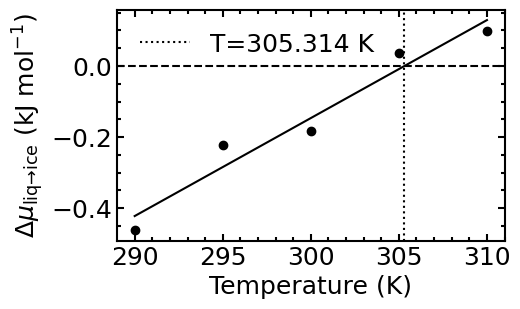

In [107]:
T_lst = np.arange(290,311,5, dtype=int)
path = f'../../full/ih/100_bar/2-coex/'
plot_chem_pot(path, T_lst)

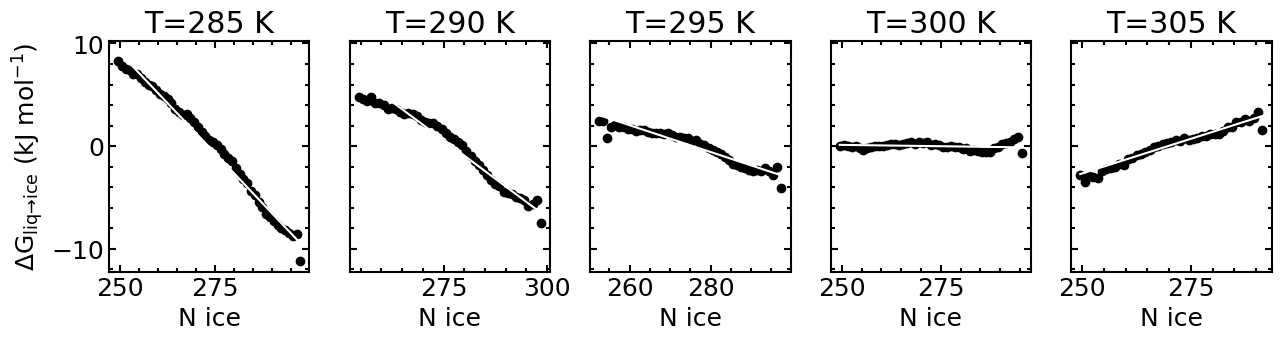

In [105]:
T_lst = np.arange(285,306,5, dtype=int)
path = f'../../full/ih/1000_bar/2-coex/'
plot_fes(path, T_lst)

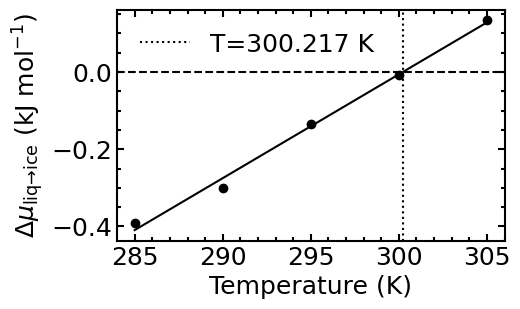

In [45]:
T_lst = np.arange(285,306,5, dtype=int)
path = f'../../full/ih/1000_bar/2-coex/'
plot_chem_pot(path, T_lst)

## Ice II

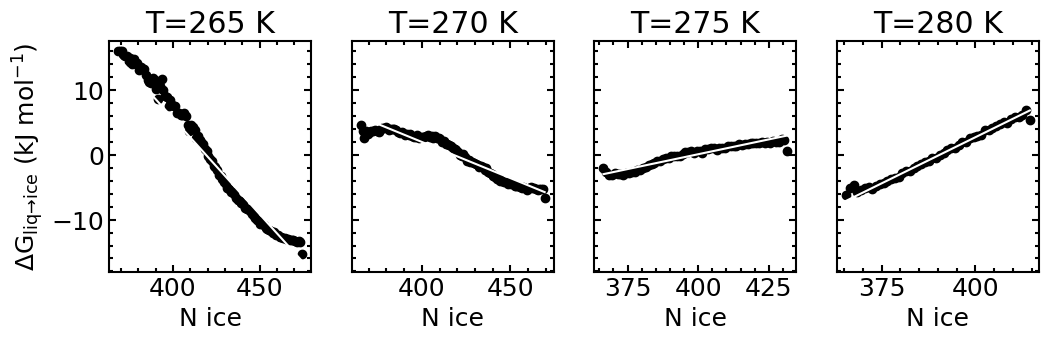

In [108]:
T_lst = np.arange(265,281,5, dtype=int)
path = f'../../full/ii/5000_bar/2-coex/'
plot_fes(path, T_lst)

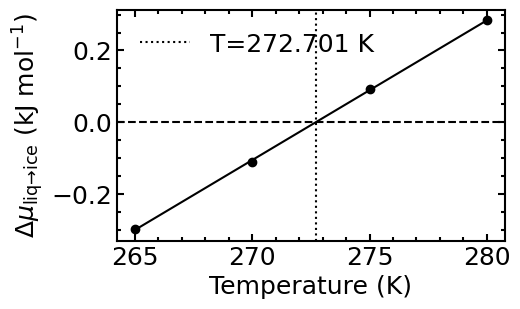

In [95]:
T_lst = np.arange(265,281,5, dtype=int)
path = f'../../full/ii/5000_bar/2-coex/'
plot_chem_pot(path, T_lst)

## Ice III

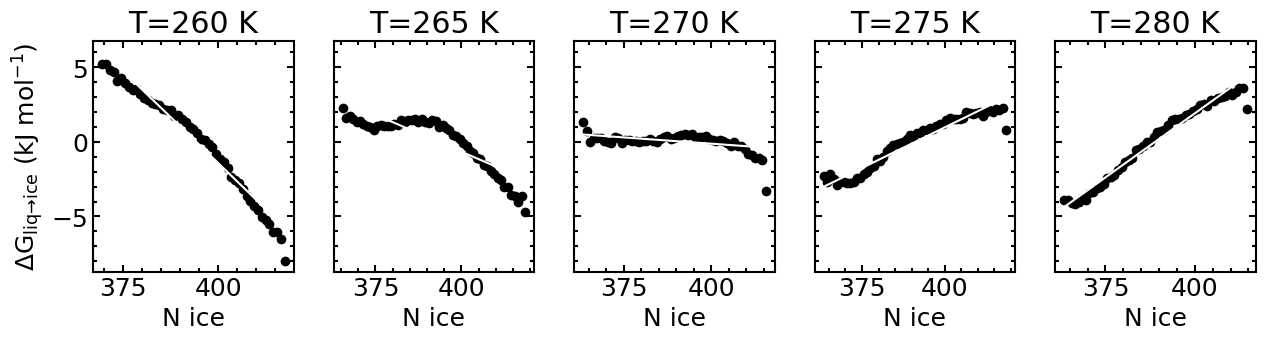

In [109]:
T_lst = np.arange(260,281,5, dtype=int)
path = f'../../full/iii/5000_bar/2-coex/'
plot_fes(path, T_lst)

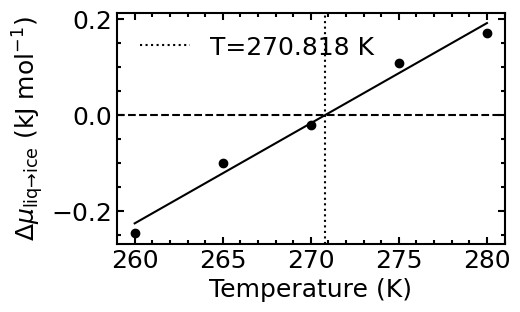

In [96]:
T_lst = np.arange(260,281,5, dtype=int)
path = f'../../full/iii/5000_bar/2-coex/'
plot_chem_pot(path, T_lst)

## Ice V

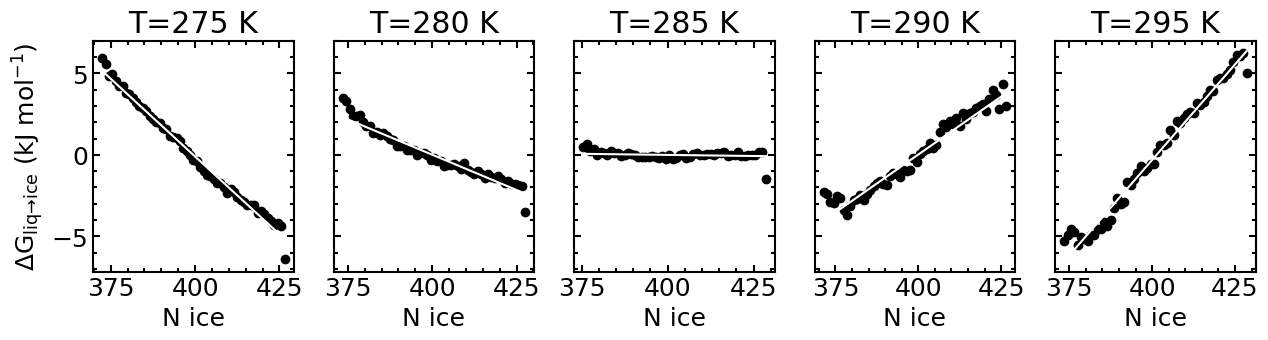

In [110]:
T_lst = np.arange(275,296,5, dtype=int)
path = f'../../full/v/5000_bar/2-coex/'
plot_fes(path, T_lst)

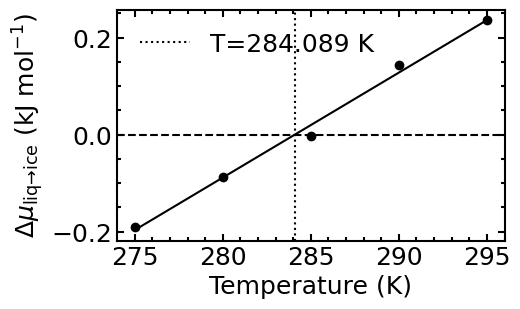

In [101]:
T_lst = np.arange(275,296,5, dtype=int)
path = f'../../full/v/5000_bar/2-coex/'
plot_chem_pot(path, T_lst)

## Ice VI

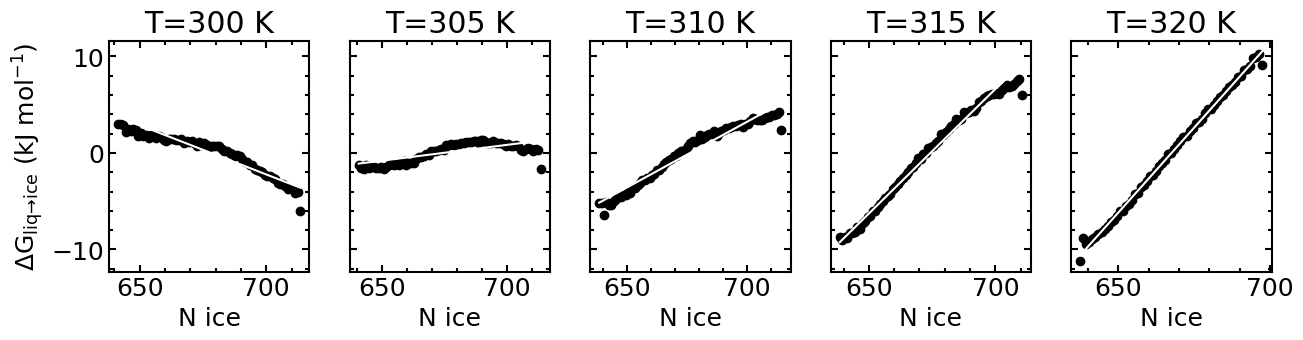

In [111]:
T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
plot_fes(path, T_lst)

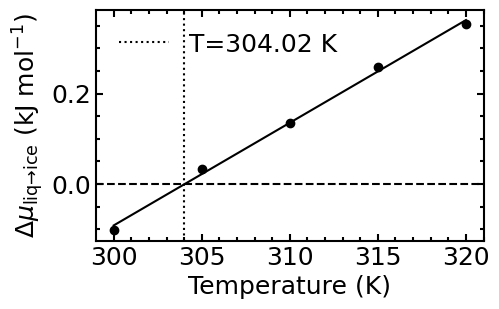

In [102]:
T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
plot_chem_pot(path, T_lst)

## Ice VII

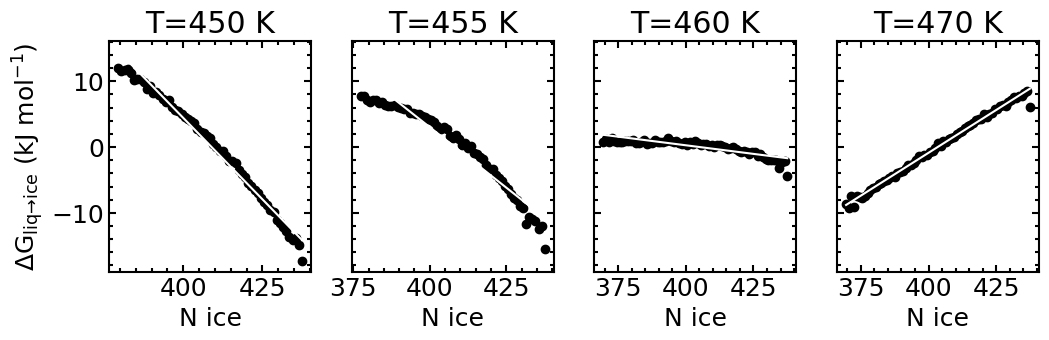

In [112]:
T_lst = [450,455,460,470]
path = f'../../full/vii/30000_bar/2-coex/'
plot_fes(path, T_lst)

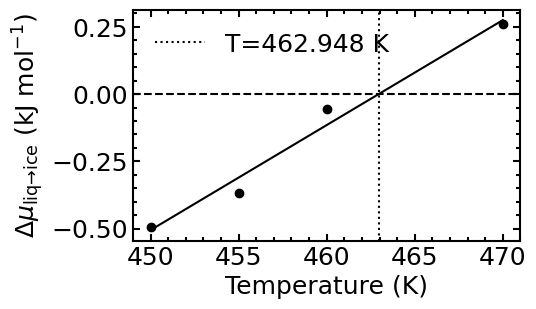

In [103]:
T_lst = [450,455,460,470]
path = f'../../full/vii/30000_bar/2-coex/'
plot_chem_pot(path, T_lst)

Text(0, 0.5, '$\\Delta G$ [kJ mol$^{-1}$]')

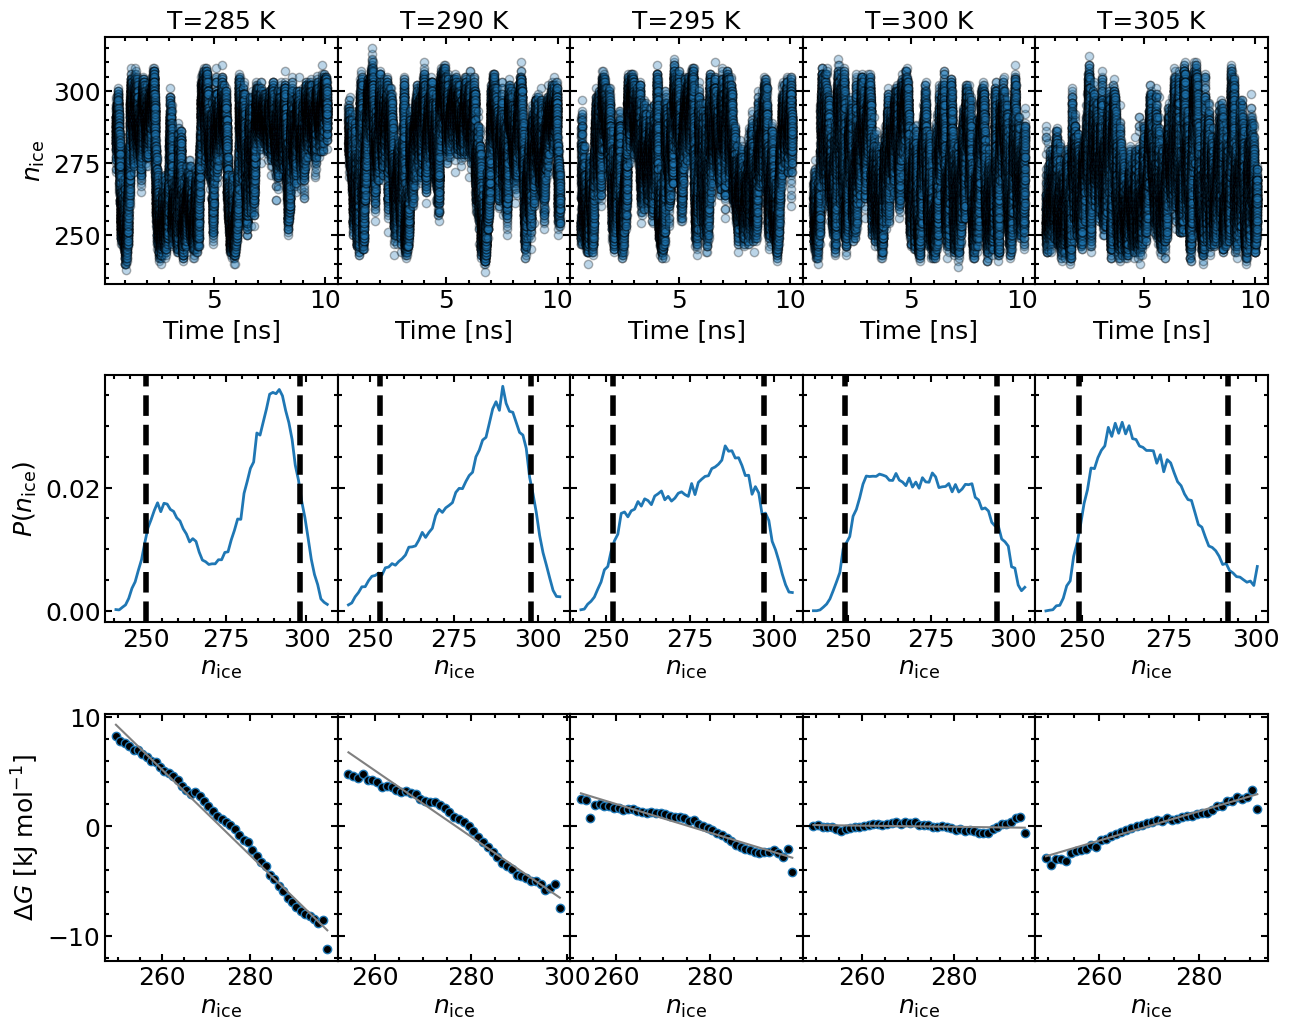

In [392]:
T_lst = np.arange(285, 306, 5, dtype=int)
path = f'../../full/ih/1000_bar/2-coex/'

fig, axs = plt.subplots(figsize=(15, 12), ncols=5, nrows=3, sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.0, hspace=0.37)

# --- share y per row ---
for j in range(1, 5):
    axs[0, j].sharey(axs[0, 0])
    axs[1, j].sharey(axs[1, 0])
    axs[2, j].sharey(axs[2, 0])

# --- plot ---
for i, T in enumerate(T_lst):
    # CV data (row 0)
    data_cv_ih = get_cv(path, T)
    axs[0, i].scatter(data_cv_ih[0], data_cv_ih[1], c='C0', ec='k', alpha=0.3)
    axs[0, i].set_title(f'T={T} K', fontsize=18)
    axs[0, i].set_xlabel(r'Time [ns]',fontsize=18)
    
for i, T in enumerate(T_lst):
    # CV histogram data (row 0)
    data_cv_hist_ih = get_cv_hist(path, T)
    axs[1, i].plot(data_cv_hist_ih[0], data_cv_hist_ih[1], c='C0', lw=2)
    axs[1, i].axvline(x=data_cv_hist_ih[2],lw=4, ls='--', c='k')
    axs[1, i].axvline(x=data_cv_hist_ih[3],lw=4, ls='--', c='k')
    axs[1, i].set_xlabel(r'$n_{\mathrm{ice}}$',fontsize=18)

    # FES data (row 2)
    data_fes_ih = get_fes(path, T)
    axs[2, i].scatter(data_fes_ih[0], data_fes_ih[1], c='k', ec='C0')
    axs[2, i].plot(data_fes_ih[0], data_fes_ih[2], c='gray')
    axs[2, i].set_xlabel(r'$n_{\mathrm{ice}}$',fontsize=18)

# --- only leftmost column shows y labels ---
for row in range(3):
    for col in range(1, 5):
        axs[row, col].tick_params(labelleft=False)  # hide only the labels, not the ticks/scale

# y-label for bottom-left panel
axs[0, 0].set_ylabel(r'$n_{\mathrm{ice}}$',fontsize=18)
axs[1, 0].set_ylabel(r'$P(n_{\mathrm{ice}})$',fontsize=18)
axs[2, 0].set_ylabel(r'$\Delta G$ [kJ mol$^{-1}$]',fontsize=18)

#fig.savefig('../figures/opes.png', bbox_inches='tight', dpi=300)

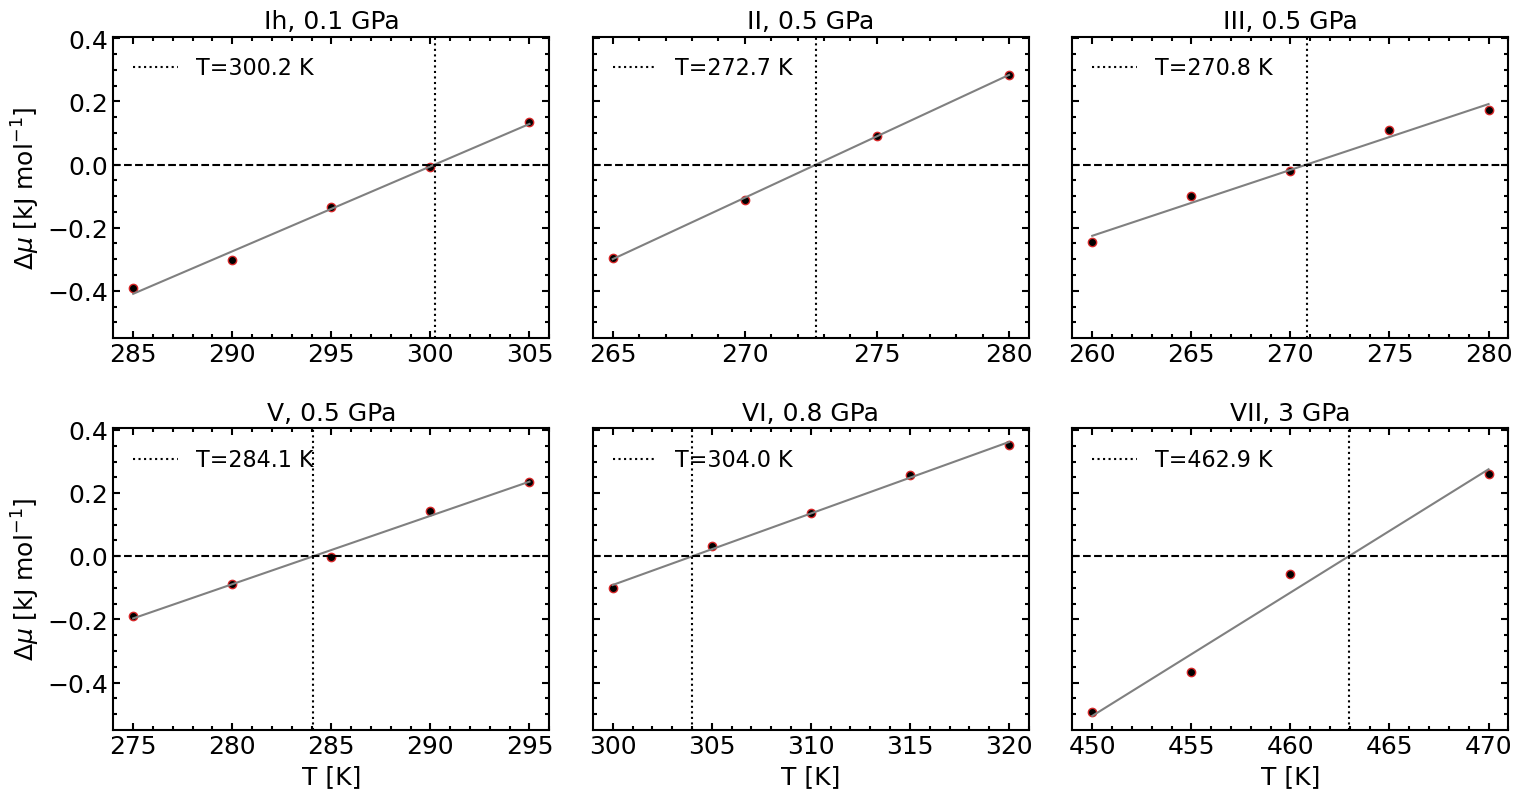

In [388]:
T_lst = np.arange(285,306,5, dtype=int)
path = f'../../full/ih/1000_bar/2-coex/'
data_chem_pot_ih = get_chem_pot(path, T_lst)

T_lst = np.arange(265,281,5, dtype=int)
path = f'../../full/ii/5000_bar/2-coex/'
data_chem_pot_ii = get_chem_pot(path, T_lst)

T_lst = np.arange(260,281,5, dtype=int)
path = f'../../full/iii/5000_bar/2-coex/'
data_chem_pot_iii = get_chem_pot(path, T_lst)

T_lst = np.arange(275,296,5, dtype=int)
path = f'../../full/v/5000_bar/2-coex/'
data_chem_pot_v = get_chem_pot(path, T_lst)

T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
data_chem_pot_vi = get_chem_pot(path, T_lst)

T_lst = [450,455,460,470]
path = f'../../full/vii/30000_bar/2-coex/'
data_chem_pot_vii = get_chem_pot(path, T_lst)



fig, axs = plt.subplots(figsize=(18,9), ncols=3, nrows=2, sharey=True)
axs = axs.flatten()
fig.subplots_adjust(hspace=0.3, wspace=0.1)

axs[0].scatter(data_chem_pot_ih[0],data_chem_pot_ih[1], c='k', ec='C3')
axs[0].plot(data_chem_pot_ih[0],data_chem_pot_ih[2], c='gray')
axs[0].axhline(0, ls='--', c='k')
axs[0].axvline(data_chem_pot_ih[3], ls=':', label=f'T={np.round(data_chem_pot_ih[3],1)} K', c='k')

axs[1].scatter(data_chem_pot_ii[0],data_chem_pot_ii[1], c='k', ec='C3')
axs[1].plot(data_chem_pot_ii[0],data_chem_pot_ii[2], c='gray')
axs[1].axhline(0, ls='--', c='k')
axs[1].axvline(data_chem_pot_ii[3], ls=':', label=f'T={np.round(data_chem_pot_ii[3],1)} K', c='k')

axs[2].scatter(data_chem_pot_iii[0],data_chem_pot_iii[1], c='k', ec='C3')
axs[2].plot(data_chem_pot_iii[0],data_chem_pot_iii[2], c='gray')
axs[2].axhline(0, ls='--', c='k')
axs[2].axvline(data_chem_pot_iii[3], ls=':', label=f'T={np.round(data_chem_pot_iii[3],1)} K', c='k')

axs[3].scatter(data_chem_pot_v[0],data_chem_pot_v[1], c='k', ec='C3')
axs[3].plot(data_chem_pot_v[0],data_chem_pot_v[2], c='gray')
axs[3].axhline(0, ls='--', c='k')
axs[3].axvline(data_chem_pot_v[3], ls=':', label=f'T={np.round(data_chem_pot_v[3],1)} K', c='k')

axs[4].scatter(data_chem_pot_vi[0],data_chem_pot_vi[1], c='k', ec='C3')
axs[4].plot(data_chem_pot_vi[0],data_chem_pot_vi[2], c='gray')
axs[4].axhline(0, ls='--', c='k')
axs[4].axvline(data_chem_pot_vi[3], ls=':', label=f'T={np.round(data_chem_pot_vi[3],1)} K', c='k')

axs[5].scatter(data_chem_pot_vii[0],data_chem_pot_vii[1], c='k', ec='C3')
axs[5].plot(data_chem_pot_vii[0],data_chem_pot_vii[2], c='gray')
axs[5].axhline(0, ls='--', c='k')
axs[5].axvline(data_chem_pot_vii[3], ls=':', label=f'T={np.round(data_chem_pot_vii[3],1)} K', c='k')

# axs[0].set_xlabel('Temperature (K)')
# axs[1].set_xlabel('Temperature (K)')
# axs[2].set_xlabel('Temperature (K)')
axs[3].set_xlabel('T [K]')
axs[4].set_xlabel('T [K]')
axs[5].set_xlabel('T [K]')


axs[0].set_ylabel(r'$\Delta\mu$ [kJ mol$^{-1}$]')
axs[3].set_ylabel(r'$\Delta\mu$ [kJ mol$^{-1}$]')

axs[0].set_title('Ih, 0.1 GPa', fontsize=18)
axs[1].set_title('II, 0.5 GPa', fontsize=18)
axs[2].set_title('III, 0.5 GPa', fontsize=18)
axs[3].set_title('V, 0.5 GPa', fontsize=18)
axs[4].set_title('VI, 0.8 GPa', fontsize=18)
axs[5].set_title('VII, 3 GPa', fontsize=18)

axs[0].legend(frameon=False, fontsize=16, loc=2)
axs[1].legend(frameon=False, fontsize=16, loc=2)
axs[2].legend(frameon=False, fontsize=16, loc=2)
axs[3].legend(frameon=False, fontsize=16, loc=2)
axs[4].legend(frameon=False, fontsize=16, loc=2)
axs[5].legend(frameon=False, fontsize=16, loc=2)

fig.savefig('../figures/chem_pots.png', bbox_inches = 'tight', dpi=300);

In [363]:
def get_fes(path, T, ign=2000, end=None):
    data = pd.read_csv(f'{path}/{T}/COLVAR', sep=r'\s+')
    data.columns = np.roll(data.columns,-2)
    dpl=0.05 # Lower probability range for strict histogram
    dph=0.05 # Upper probability range for strict histogram
    dh=1     # Bin size used for histogram
    number_of_ice  = data['refcv2.morethan'].values
    bias_potential = data['opes.bias'].values

    if end is None:
        number_of_ice = number_of_ice[ign:]
        bias_potential = bias_potential[ign:]
    else:
        number_of_ice = number_of_ice[ign:end]
        bias_potential = bias_potential[ign:end]


    histo, bin_edges = np.histogram(number_of_ice,bins=80)
    n_ice_mid=0.5*(bin_edges[1:]+bin_edges[:-1])

    # Determine outer range of strict collective variable histogram
    cumsum=np.cumsum(histo)
    cumsum=cumsum/cumsum.max()
    difference=np.abs(cumsum-dpl)
    ns=int(n_ice_mid[np.where(difference==difference.min())[0][0]])
    difference=np.abs(cumsum-(1-dph))
    nf=int(n_ice_mid[np.where(difference==difference.min())[0][0]])


    # Plot biased histogram
    num_ice_bins=[i for i in range(ns,nf+1)]

    beta = 1./(0.00831441001626*T) # 1/(kJ/mol)

    logweights = beta*bias_potential
    logweights -= np.amax( logweights)

    bins=num_ice_bins[::dh]
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])
    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    fes_error = (1/beta)*histo_error/histo
    bin_centers = bin_centers

    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error, maxfev=100)
    dmu = popt[0]
    dmu_err_fit = np.sqrt(pcov[0,0])

    return dmu, dmu_err_fit

def dmu_block_uncertainty(path, T, ign=2000, nblocks=10):
    data = pd.read_csv(f'{path}/{T}/COLVAR', sep=r'\s+')
    data.columns = np.roll(data.columns,-2)

    n = len(data)
    start = ign
    usable = n - start
    block_len = usable // nblocks

    dmus = []
    for i in range(nblocks):
        b0 = start + i*block_len
        b1 = start + (i+1)*block_len if i < nblocks-1 else n
        dmu_i, _ = get_fes(path, T, ign=b0, end=b1)  # uses only that block
        dmus.append(dmu_i)

    dmus = np.array(dmus)
    dmu_mean = dmus.mean()
    dmu_sem  = dmus.std(ddof=1) / np.sqrt(nblocks)  # standard error of mean
    return dmu_mean, dmu_sem, dmus

In [368]:
def get_dmu_from_block(path, T, start, end, dpl=0.05, dph=0.05, dh=1, nbins0=300):
    data = pd.read_csv(f'{path}/{T}/COLVAR', sep=r'\s+')
    data.columns = np.roll(data.columns, -2)

    number_of_ice  = data['refcv2.morethan'].values[start:end]
    bias_potential = data['opes.bias'].values[start:end]

    # --- determine strict CV window (same as your code) ---
    histo, bin_edges = np.histogram(number_of_ice, bins=nbins0)
    n_ice_mid = 0.5*(bin_edges[1:]+bin_edges[:-1])

    cumsum = np.cumsum(histo)
    cumsum = cumsum / cumsum.max()

    ns = int(n_ice_mid[np.argmin(np.abs(cumsum - dpl))])
    nf = int(n_ice_mid[np.argmin(np.abs(cumsum - (1 - dph)))])

    bins = list(range(ns, nf+1, dh))

    beta = 1./(0.00831441001626*T)  # 1/(kJ/mol)

    logw = beta*bias_potential
    logw -= np.max(logw)
    w = np.exp(logw)

    histo_w, bin_edges = np.histogram(number_of_ice, weights=w, bins=bins)
    histo_w2, _        = np.histogram(number_of_ice, weights=w**2, bins=bins)
    histo_err = np.sqrt(histo_w2)

    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    # Avoid divide-by-zero bins
    mask = (histo_w > 0) & np.isfinite(histo_w) & np.isfinite(histo_err)
    bin_centers = bin_centers[mask]
    histo_w = histo_w[mask]
    histo_err = histo_err[mask]

    fes = -(1/beta)*np.log(histo_w)
    fes -= np.mean(fes)

    fes_err = (1/beta) * histo_err / histo_w
    fes_err = np.where(fes_err > 0, fes_err, np.nan)

    # Weighted linear fit to extract slope = Δμ
    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_err, absolute_sigma=True, maxfev=10000)
    dmu = popt[0]
    dmu_fit_err = np.sqrt(pcov[0,0])

    return dmu, dmu_fit_err
def dmu_with_block_uncertainty(path, T, ign=2000, nblocks=10):
    data = pd.read_csv(f'{path}/{T}/COLVAR', sep=r'\s+')
    n = len(data)

    start = ign
    usable = n - start
    if usable <= 0:
        raise ValueError(f"Not enough frames after ign={ign} for T={T}")

    block_len = usable // nblocks
    if block_len < 50:
        # safety: blocks too short -> reduce number of blocks
        nblocks = max(2, usable // 50)
        block_len = usable // nblocks

    dmus = []
    for i in range(nblocks):
        b0 = start + i*block_len
        b1 = start + (i+1)*block_len if i < nblocks-1 else n
        dmu_i, _ = get_dmu_from_block(path, T, b0, b1)
        dmus.append(dmu_i)

    dmus = np.array(dmus, dtype=float)
    dmu_mean = np.mean(dmus)
    dmu_sem  = np.std(dmus, ddof=1) / np.sqrt(len(dmus))  # SEM

    return dmu_mean, dmu_sem, dmus
def fit_Teq_with_uncertainty(T_vals, dmu_vals, dmu_errs):
    T_vals = np.array(T_vals, dtype=float)
    dmu_vals = np.array(dmu_vals, dtype=float)
    dmu_errs = np.array(dmu_errs, dtype=float)

    popt, pcov = curve_fit(linear_fn, T_vals, dmu_vals, sigma=dmu_errs,
                           absolute_sigma=True, maxfev=10000)
    m, b = popt
    Teq = -b/m

    # propagate error using covariance of m,b
    var_Teq = (pcov[1,1]/m**2) + (b**2 * pcov[0,0]/m**4) - (2*b*pcov[0,1]/m**3)
    Teq_err = np.sqrt(var_Teq)

    return Teq, Teq_err, popt, pcov
def get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10):
    dmu_list = []
    dmu_err_list = []

    for T in T_lst:
        dmu_mean, dmu_sem, _ = dmu_with_block_uncertainty(path, T, ign=ign, nblocks=nblocks)
        dmu_list.append(dmu_mean)
        dmu_err_list.append(dmu_sem)

    Teq, Teq_err, popt, pcov = fit_Teq_with_uncertainty(T_lst, dmu_list, dmu_err_list)

    # For plotting: linear fit line
    fit_line = linear_fn(np.array(T_lst, dtype=float), *popt)

    return (np.array(T_lst), np.array(dmu_list), np.array(dmu_err_list),
            fit_line, Teq, Teq_err)

In [370]:
T_lst = np.arange(285,306,5, dtype=int)
path = '../../full/ih/1000_bar/2-coex/'
data_chem_pot_ih = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_ih

(array([285, 290, 295, 300, 305]),
 array([-0.39783058, -0.29823171, -0.1310828 , -0.00952666,  0.14332705]),
 array([0.0385402 , 0.04114049, 0.02399392, 0.01298097, 0.02450809]),
 array([-0.41228984, -0.27625388, -0.14021792, -0.00418196,  0.13185401]),
 300.1537077789925,
 0.3766222951141114)

In [371]:
T_lst = np.arange(265,281,5, dtype=int)
path = f'../../full/ii/5000_bar/2-coex/'
data_chem_pot_ii = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_ii

(array([265, 270, 275, 280]),
 array([-0.21176054, -0.13477122,  0.0341742 ,  0.24681892]),
 array([0.01213624, 0.03513254, 0.04354624, 0.03719059]),
 array([-0.21733475, -0.07529953,  0.0667357 ,  0.20877092]),
 272.65073426832146,
 0.5731721081247922)

In [372]:
T_lst = np.arange(260,281,5, dtype=int)
path = f'../../full/iii/5000_bar/2-coex/'
data_chem_pot_iii = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_iii

(array([260, 265, 270, 275, 280]),
 array([-0.27574526, -0.13415898, -0.02269366,  0.10353443,  0.16677504]),
 array([0.04257733, 0.04369653, 0.02885585, 0.02470459, 0.02332669]),
 array([-0.24624502, -0.138094  , -0.02994298,  0.07820804,  0.18635906]),
 271.3843133104267,
 0.6338986401678077)

In [373]:
T_lst = np.arange(275,296,5, dtype=int)
path = f'../../full/v/5000_bar/2-coex/'
data_chem_pot_v = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_v

(array([275, 280, 285, 290, 295]),
 array([-0.19066543, -0.0858883 , -0.00761208,  0.10360428,  0.20375133]),
 array([0.01756509, 0.01699258, 0.01623566, 0.0169811 , 0.02337782]),
 array([-0.1907693 , -0.09341735,  0.0039346 ,  0.10128655,  0.1986385 ]),
 284.79791876325356,
 0.41094828287901686)

In [374]:
T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
data_chem_pot_vi = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_vi

(array([300, 305, 310, 315, 320]),
 array([-0.10361999,  0.02879065,  0.1200747 ,  0.25120731,  0.3394554 ]),
 array([0.02307657, 0.02792285, 0.02345549, 0.02464362, 0.00691318]),
 array([-0.0938492 ,  0.01477744,  0.12340408,  0.23203072,  0.34065736]),
 304.31980582504656,
 0.642393024159182)

In [375]:
T_lst = [450,455,460,470]
path = f'../../full/vii/30000_bar/2-coex/'
T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
data_chem_pot_vii = get_chem_pot_with_uncertainty(path, T_lst, ign=2000, nblocks=10)
data_chem_pot_vii

(array([300, 305, 310, 315, 320]),
 array([-0.10361999,  0.02879065,  0.1200747 ,  0.25120731,  0.3394554 ]),
 array([0.02307657, 0.02792285, 0.02345549, 0.02464362, 0.00691318]),
 array([-0.0938492 ,  0.01477744,  0.12340408,  0.23203072,  0.34065736]),
 304.31980582504656,
 0.642393024159182)

In [199]:
bg_img = plt.imread('../figures/Screenshot 2025-11-06 at 20.28.55.png')

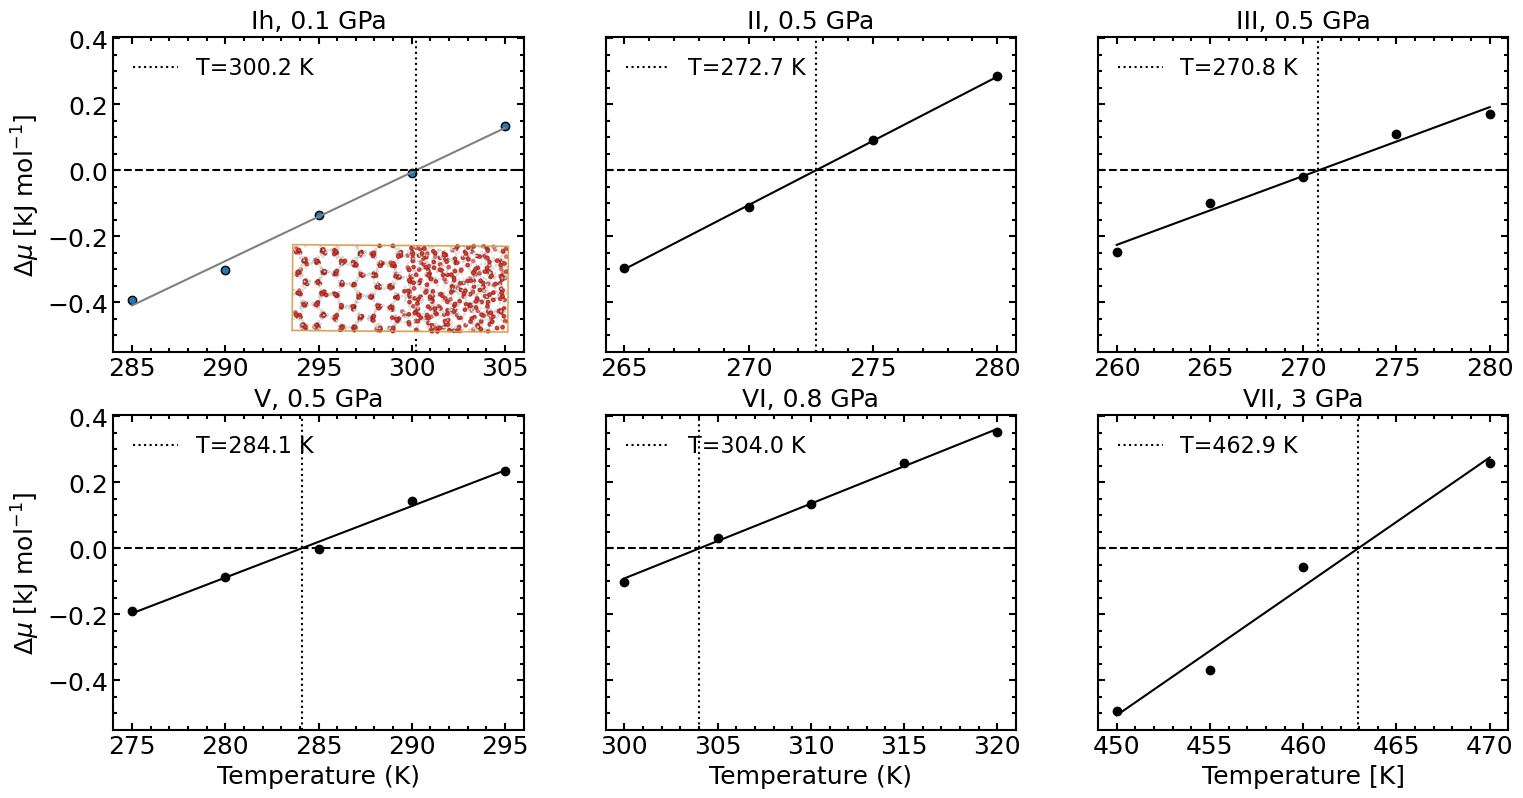

In [225]:
T_lst = np.arange(285,306,5, dtype=int)
path = f'../../full/ih/1000_bar/2-coex/'
data_chem_pot_ih = get_chem_pot(path, T_lst)

T_lst = np.arange(265,281,5, dtype=int)
path = f'../../full/ii/5000_bar/2-coex/'
data_chem_pot_ii = get_chem_pot(path, T_lst)

T_lst = np.arange(260,281,5, dtype=int)
path = f'../../full/iii/5000_bar/2-coex/'
data_chem_pot_iii = get_chem_pot(path, T_lst)

T_lst = np.arange(275,296,5, dtype=int)
path = f'../../full/v/5000_bar/2-coex/'
data_chem_pot_v = get_chem_pot(path, T_lst)

T_lst = np.arange(300,321,5, dtype=int)
path = f'../../full/vi/8000_bar/2-coex/'
data_chem_pot_vi = get_chem_pot(path, T_lst)

T_lst = [450,455,460,470]
path = f'../../full/vii/30000_bar/2-coex/'
data_chem_pot_vii = get_chem_pot(path, T_lst)



fig, axs = plt.subplots(figsize=(18,9), ncols=3, nrows=2, sharey=True)
axs = axs.flatten()
#fig.subplots_adjust(wspace=0.8)

# bg_img = plt.imread('../figures/Screenshot 2025-11-06 at 20.52.48.png')
# ax_inset = axs[0].inset_axes([0.4, 0.05, 0.6, 0.3])
# ax_inset.imshow(bg_img) 
# ax_inset.set_yticklabels([])
# ax_inset.set_xticklabels([], minor=False)
# ax_inset.tick_params(axis='both', which='both', length=0)
# ax_inset.spines['top'].set_visible(False)
# ax_inset.spines['right'].set_visible(False)
# ax_inset.spines['left'].set_visible(False)
# ax_inset.spines['bottom'].set_visible(False)

axs[0].scatter(data_chem_pot_ih[0],data_chem_pot_ih[1], ec='k', c='C0')
axs[0].plot(data_chem_pot_ih[0],data_chem_pot_ih[2], c='gray')
axs[0].axhline(0, ls='--', c='k')
axs[0].axvline(data_chem_pot_ih[3], ls=':', label=f'T={np.round(data_chem_pot_ih[3],1)} K', c='k')




axs[1].scatter(data_chem_pot_ii[0],data_chem_pot_ii[1], c='k')
axs[1].plot(data_chem_pot_ii[0],data_chem_pot_ii[2], c='k')
axs[1].axhline(0, ls='--', c='k')
axs[1].axvline(data_chem_pot_ii[3], ls=':', label=f'T={np.round(data_chem_pot_ii[3],1)} K', c='k')

axs[2].scatter(data_chem_pot_iii[0],data_chem_pot_iii[1], c='k')
axs[2].plot(data_chem_pot_iii[0],data_chem_pot_iii[2], c='k')
axs[2].axhline(0, ls='--', c='k')
axs[2].axvline(data_chem_pot_iii[3], ls=':', label=f'T={np.round(data_chem_pot_iii[3],1)} K', c='k')

axs[3].scatter(data_chem_pot_v[0],data_chem_pot_v[1], c='k')
axs[3].plot(data_chem_pot_v[0],data_chem_pot_v[2], c='k')
axs[3].axhline(0, ls='--', c='k')
axs[3].axvline(data_chem_pot_v[3], ls=':', label=f'T={np.round(data_chem_pot_v[3],1)} K', c='k')

axs[4].scatter(data_chem_pot_vi[0],data_chem_pot_vi[1], c='k')
axs[4].plot(data_chem_pot_vi[0],data_chem_pot_vi[2], c='k')
axs[4].axhline(0, ls='--', c='k')
axs[4].axvline(data_chem_pot_vi[3], ls=':', label=f'T={np.round(data_chem_pot_vi[3],1)} K', c='k')

axs[5].scatter(data_chem_pot_vii[0],data_chem_pot_vii[1], c='k')
axs[5].plot(data_chem_pot_vii[0],data_chem_pot_vii[2], c='k')
axs[5].axhline(0, ls='--', c='k')
axs[5].axvline(data_chem_pot_vii[3], ls=':', label=f'T={np.round(data_chem_pot_vii[3],1)} K', c='k')

# axs[0].set_xlabel('Temperature (K)')
# axs[1].set_xlabel('Temperature (K)')
# axs[2].set_xlabel('Temperature (K)')
axs[3].set_xlabel('Temperature (K)')
axs[4].set_xlabel('Temperature (K)')
axs[5].set_xlabel('Temperature [K]')


axs[0].set_ylabel(r'$\Delta\mu$ [kJ mol$^{-1}$]')
axs[3].set_ylabel(r'$\Delta\mu$ [kJ mol$^{-1}$]')

axs[0].set_title('Ih, 0.1 GPa', fontsize=18)
axs[1].set_title('II, 0.5 GPa', fontsize=18)
axs[2].set_title('III, 0.5 GPa', fontsize=18)
axs[3].set_title('V, 0.5 GPa', fontsize=18)
axs[4].set_title('VI, 0.8 GPa', fontsize=18)
axs[5].set_title('VII, 3 GPa', fontsize=18)

axs[0].legend(frameon=False, fontsize=16, loc=2)
axs[1].legend(frameon=False, fontsize=16, loc=2)
axs[2].legend(frameon=False, fontsize=16, loc=2)
axs[3].legend(frameon=False, fontsize=16, loc=2)
axs[4].legend(frameon=False, fontsize=16, loc=2)
axs[5].legend(frameon=False, fontsize=16, loc=2)


In [193]:
atoms_ih = io.read('../ih/1000_bar/2-coex/285/water.dat', format='lammps-data', style='atomic')
atoms_ih.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_ih.get_chemical_symbols())))
atoms_ih.wrap()
view(atoms_ih, viewer='nglview')

In [194]:
atoms_ii = io.read('../ii/5000_bar/2-coex/260/water.dat', format='lammps-data', style='atomic')
atoms_ii.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_ii.get_chemical_symbols())))
atoms_ii.wrap()
view(atoms_ii, viewer='nglview')

In [196]:
atoms_iii = io.read('../iii/5000_bar/2-coex/260/water.dat', format='lammps-data', style='atomic')
atoms_iii.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_iii.get_chemical_symbols())))
atoms_iii.wrap()
view(atoms_iii, viewer='nglview')

In [197]:
atoms_v = io.read('../v/5000_bar/2-coex/275/water.dat', format='lammps-data', style='atomic')
atoms_v.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_v.get_chemical_symbols())))
atoms_v.wrap()
view(atoms_v, viewer='nglview')

In [198]:
atoms_vi = io.read('../vi/8000_bar/2-coex/300/water.dat', format='lammps-data', style='atomic')
atoms_vi.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_vi.get_chemical_symbols())))
atoms_vi.wrap()
view(atoms_vi, viewer='nglview')

In [192]:
atoms_vii = io.read('../vii/30000_bar/2-coex/450/water.dat', format='lammps-data', style='atomic')
atoms_vii.set_chemical_symbols(list(map(lambda s: 'O' if s == 'He' else s, atoms_vii.get_chemical_symbols())))
atoms_vii.wrap()
view(atoms_vii, viewer='nglview')